<a href="https://colab.research.google.com/github/ebokoh/cattleBreeds_Prediction/blob/main/cattle_breeds_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

1.13.1+cu116


In [3]:
myCattlePaths = "/content/drive/MyDrive/myData/Cattle Breeds"

In [5]:
myCattlePaths

'/content/drive/MyDrive/myData/Cattle Breeds'

In [6]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [12]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/myFunctions/")

In [14]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from modular import data_setup, engine, utils
from helper_functions import download_data, set_seeds, plot_loss_curves

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the modular directory
# try:
#     from going_modular.going_modular import data_setup, engine, utils
#     from helper_functions import download_data, set_seeds, plot_loss_curves
# except:
#     # Get the going_modular scripts
#     print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
#     !git clone https://github.com/mrdbourke/pytorch-deep-learning
#     !mv pytorch-deep-learning/going_modular .
#     !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
#     !rm -rf pytorch-deep-learning
#     from going_modular.going_modular import data_setup, engine
#     from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [15]:
from imutils import paths
import numpy as np
from PIL import Image
import os
import shutil
import pandas as pd

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
imagePaths = list(paths.list_images(myCattlePaths))

classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [18]:
pd.DataFrame(imagePaths).head()

,0
0,/content/drive/MyDrive/myData/Cattle Breeds/Ho...
1,/content/drive/MyDrive/myData/Cattle Breeds/Ho...
2,/content/drive/MyDrive/myData/Cattle Breeds/Ho...
3,/content/drive/MyDrive/myData/Cattle Breeds/Ho...
4,/content/drive/MyDrive/myData/Cattle Breeds/Ho...


In [19]:
def split_dataset(dataset: torchvision.datasets, split_size: float = 0.2, seed: int = 42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size)  # desired length
    length_2 = len(dataset) - length_1  # remaining length

    # Print out info
    print(
        f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size * 100)}%), {length_2} ({int((1 - split_size) * 100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(
                                                                       seed))  # set the random seed for reproducible splits
    return random_split_1, random_split_2


def load_images(imagePaths, verbose=-1):
    # initialize the list of features and labels
    data = []
    labels = []
    imagepaths = []

    # loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
        # load the image and extract the class label assuming
        # that our path has the following format:
        # /path/to/dataset/{class}/{image}.jpg
        image = Image.open(imagePath)
        label = imagePath.split(os.path.sep)[-2]

        # treat our processed image as a "feature vector"
        # by updating the data list followed by the labels
        data.append(image)
        labels.append(label)
        imagepaths.append(imagePath)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1,
                                                  len(imagePaths)))

    # return a tuple of the data and labels
    return data, labels, imagepaths


def copy_images(imagePaths, folder):
    # check if the destination folder exists and if not create it
    if not os.path.exists(folder):
        os.makedirs(folder)
    # loop over the image paths
    for path in imagePaths:
        # grab image name and its label from the path and create
        # a placeholder corresponding to the separate label folder
        imageName = path.split(os.path.sep)[-1]
        label = path.split(os.path.sep)[-2]
        label = os.path.basename(label)
        labelFolder = os.path.join(folder, label)
        # check to see if the label folder exists and if not create it
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)
        # construct the destination image path and copy the current
        # image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)


def create_vit_model(num_classes: int = 5,
                     seed: int = 42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transform_data = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,  # keep this the same as original model
                                          out_features=num_classes))  # update to reflect target number of classes

    return model, transform_data

In [ ]:
#data_30_percent, _ = split_dataset(dataset=imagePaths, split_size=0.3)
#data_30_percent = [data_30_percent.dataset[i] for i in data_30_percent.indices]

In [ ]:
# generate training and validation paths
# testPathsLen = int(len(imagePaths) * 0.2)
# trainPathsLen = len(imagePaths) - testPathsLen
# trainPaths = imagePaths[:trainPathsLen]
# testPaths = imagePaths[trainPathsLen:]

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
def load_images(imagePaths, verbose=-1):
    # initialize the list of features and labels
    data = []
    labels = []
    imagepaths = []

    # loop over the input images
    for (i, imagePath) in enumerate(imagePaths):
        # load the image and extract the class label assuming
        # that our path has the following format:
        # /path/to/dataset/{class}/{image}.jpg
        image = Image.open(imagePath)
        label = imagePath.split(os.path.sep)[-2]

        # treat our processed image as a "feature vector"
        # by updating the data list followed by the labels
        data.append(image)
        labels.append(label)
        imagepaths.append(imagePath)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1,
                                                  len(imagePaths)))

    # return a tuple of the data and labels
    return data, labels, imagepaths

In [22]:
data, labels, imagepaths = load_images(imagePaths, verbose=500)

[INFO] processed 500/1000
[INFO] processed 1000/1000


In [23]:
trainPaths, testPaths, _, _ = train_test_split(imagepaths, labels, test_size=0.2, random_state=42)

In [24]:
copy_images(trainPaths, "data/train")
copy_images(testPaths, "data/test")

In [25]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=5, seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [26]:
# Create ViT training data transforms (only perform data augmentation on the training images)
vit_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

In [27]:
print(f"Training transforms:\n{vit_train_transforms}\n") 
print(f"Testing transforms:\n{vit_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

Testing transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [28]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")
# data_dir = Path("/content/drive/MyDrive/myData/data")

In [29]:
# Get training data 
train_data = datasets.ImageFolder(root=data_dir/"train",
                              transform=vit_train_transforms)

# Get testing data 
test_data = datasets.ImageFolder(root=data_dir/"test",
                             transform=vit_transforms)

In [30]:
# Get class names
cattle_class_names = train_data.classes

# View the first 10
cattle_class_names[:10]

['Ayrshire cattle',
 'Brown Swiss cattle',
 'Holstein Friesian cattle',
 'Jersey cattle',
 'Red Dane cattle']

In [31]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_vit = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_vit = torch.utils.data.DataLoader(test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)

In [32]:
summary(vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Setup ViT DataLoaders
# train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir="data/train",
                                                                                      #  test_dir="data/test",
                                                                                      #  transform=vit_transforms,
                                                                                      #  batch_size=32)

In [33]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

In [34]:
# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=15,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3529 | train_acc: 0.5325 | test_loss: 1.1424 | test_acc: 0.6696
Epoch: 2 | train_loss: 1.0120 | train_acc: 0.7550 | test_loss: 1.0075 | test_acc: 0.6964
Epoch: 3 | train_loss: 0.9078 | train_acc: 0.7863 | test_loss: 0.9492 | test_acc: 0.7277
Epoch: 4 | train_loss: 0.8823 | train_acc: 0.7887 | test_loss: 0.9044 | test_acc: 0.7411
Epoch: 5 | train_loss: 0.8266 | train_acc: 0.8263 | test_loss: 0.8757 | test_acc: 0.7500
Epoch: 6 | train_loss: 0.7916 | train_acc: 0.8363 | test_loss: 0.8859 | test_acc: 0.7679
Epoch: 7 | train_loss: 0.7768 | train_acc: 0.8488 | test_loss: 0.8327 | test_acc: 0.7545
Epoch: 8 | train_loss: 0.7347 | train_acc: 0.8675 | test_loss: 0.8386 | test_acc: 0.7857
Epoch: 9 | train_loss: 0.7381 | train_acc: 0.8600 | test_loss: 0.8279 | test_acc: 0.7902
Epoch: 10 | train_loss: 0.7247 | train_acc: 0.8588 | test_loss: 0.7788 | test_acc: 0.8214
Epoch: 11 | train_loss: 0.7127 | train_acc: 0.8775 | test_loss: 0.7815 | test_acc: 0.8304
Epoch: 12 | train_l

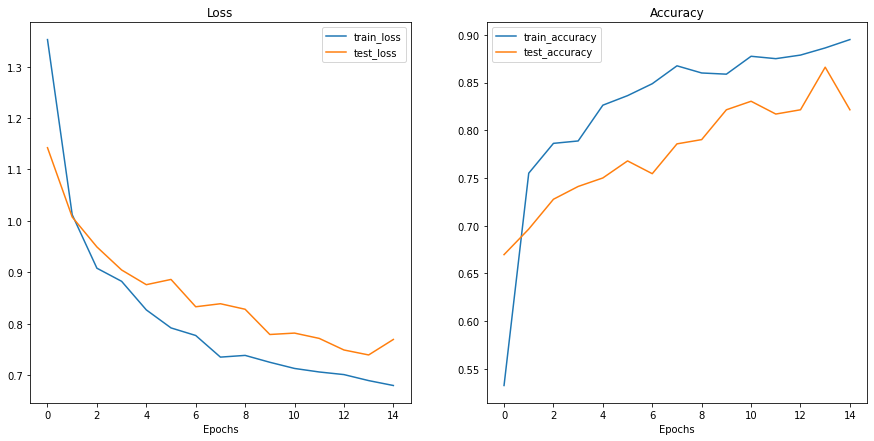

In [35]:
plot_loss_curves(vit_results)

In [36]:
# Save the model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="04_pretrained_vit_feature_extractor_cattle_breeds.pth")

[INFO] Saving model to: models/04_pretrained_vit_feature_extractor_cattle_breeds.pth


In [37]:
from google.colab import files
files.download("/content/models/04_pretrained_vit_feature_extractor_cattle_breeds.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>